# CCASS Dataset - Holding Patterns Analysis
                                         Michael Wang
 
 主要分析各个broker持股模式，寻找规律


# 【3】Time Series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set()
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

In [2]:
import os
os.chdir(r"\\UBSPROD.MSAD.UBS.NET\UserData\wangmaa\RF\Desktop\20190710 CCASS Holding Patterns\\")
path = os.getcwd()

In [3]:
df_all = pd.read_hdf('df_all.h5','data')
idmap = pd.read_csv(r"C:\Users\Public\Local Data\map.csv", delimiter='|')
mapping = idmap[['SHCMapUUID','SHC_NAME']].drop_duplicates().set_index('SHCMapUUID').squeeze()

In [4]:
mapping = mapping.apply(lambda x:x.strip("有限公司"))

In [5]:
def plot_broker(broker_id, method='holding', top=False):
    broker_name = mapping[broker_id]
    t = df_all[df_all['id']==broker_id]
    
    if method == 'holding':
        t = t.pivot_table(index='date', columns='symbol2', values='holdvol')
        title = "Holding Shares - " + broker_name
    elif method == 'value':
        t = t.pivot_table(index='date', columns='symbol2', values='holdValue')
        title = "Market Value - " + broker_name
    if top:
        topStock = t.mean().sort_values(ascending=False).iloc[:top].index
    else:
        topStock = t.columns
    try:
        t[topStock].plot(figsize=(12,6), legend=top, title=title)
    except TypeError as e:
        print(e)
    

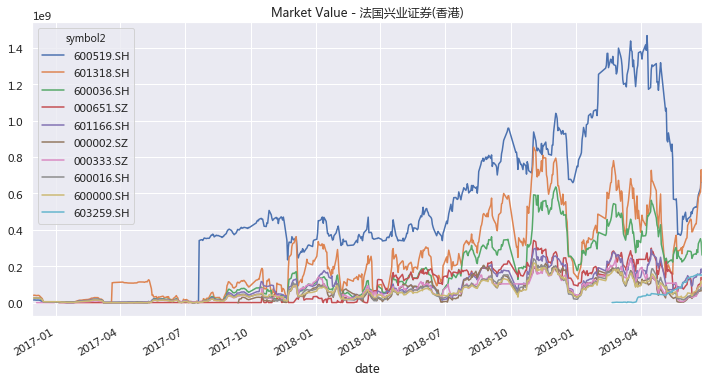

In [76]:
plot_broker(broker_id=246, method='value', top=10)

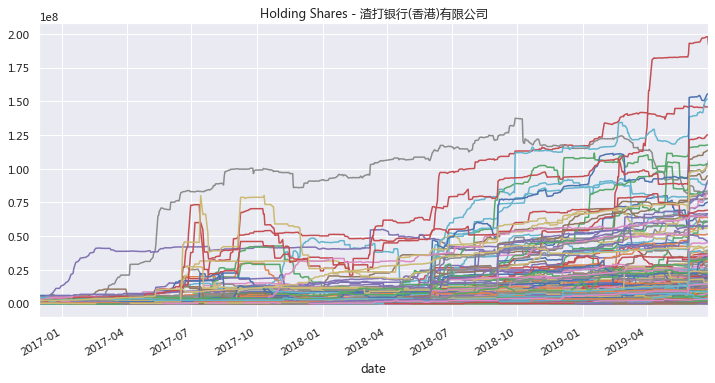

In [48]:
plot_broker(broker_id=20, method='holding', top=False)
plt.savefig('img\\holding shares - %s.png' % mapping[20], bbox_inches ='tight',dpi=100,transparent=True)

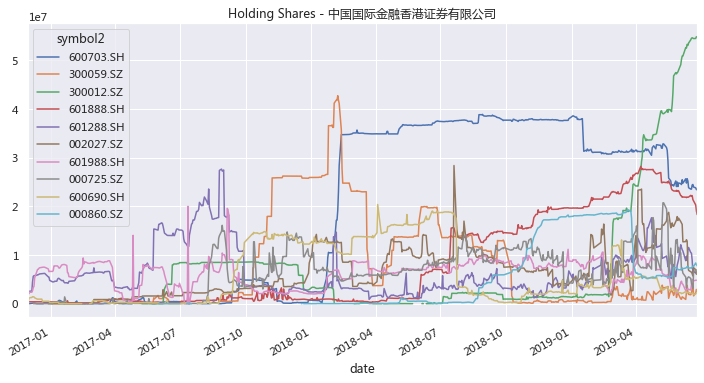

In [121]:
plot_broker(broker_id=211, method='holding', top=10)

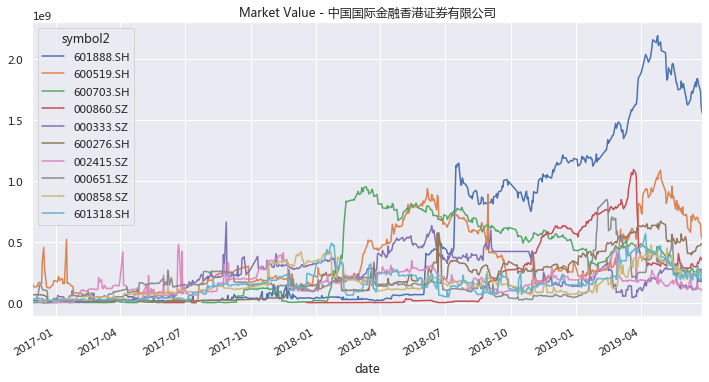

In [120]:
plot_broker(broker_id=211, method='value', top=10)

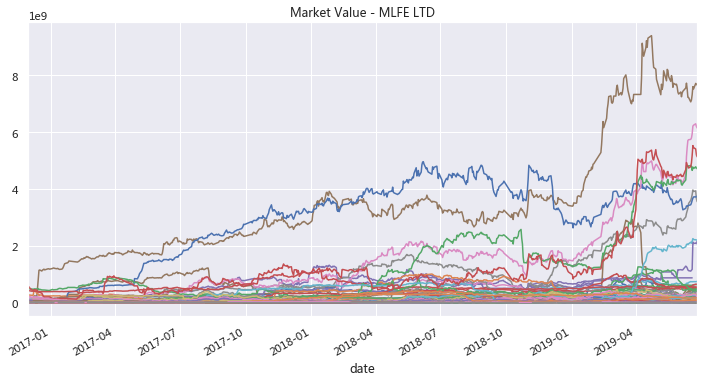

In [124]:
plot_broker(broker_id=118, method='value', top=False)

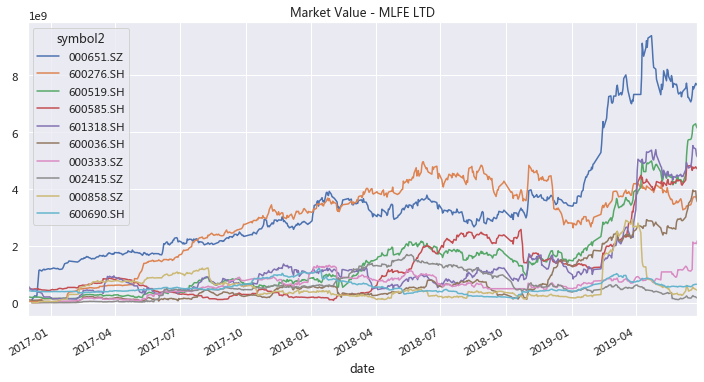

In [125]:
plot_broker(broker_id=118, method='value', top=10)

#### 非常典型的被动持有指数
- 2018-06的时间点
- 有层次的持仓

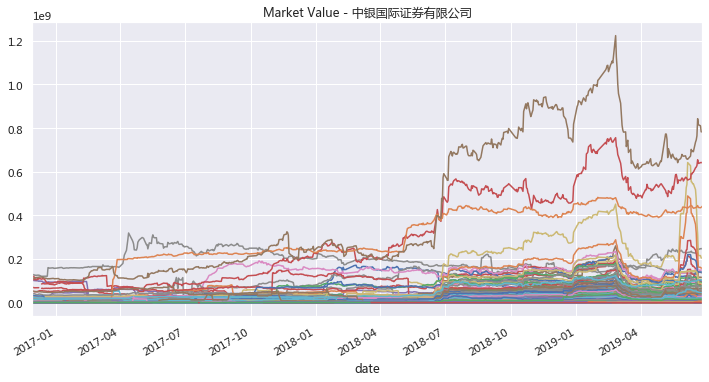

In [133]:
plot_broker(broker_id=144, method='value', top=False)

In [ ]:
plot_broker(broker_id=144, method='holding', top=10)

## 持仓数据时间序列
- 持仓金额: t_value
- 持仓份数: t_share

In [187]:
t_value = df_all.pivot_table(index='date',columns = 'id',values='holdValue', aggfunc='sum')
t_value.columns = t_value.columns.to_series().map(mapping).to_list()
t_value = t_value.sort_values('2019-06-26', axis=1, ascending=False)
t_share = df_all.pivot_table(index='date',columns = 'id',values='holdvol', aggfunc='sum')
t_share.columns = t_share.columns.to_series().map(mapping).to_list()
t_share = t_share.sort_values('2019-06-26', axis=1, ascending=False)

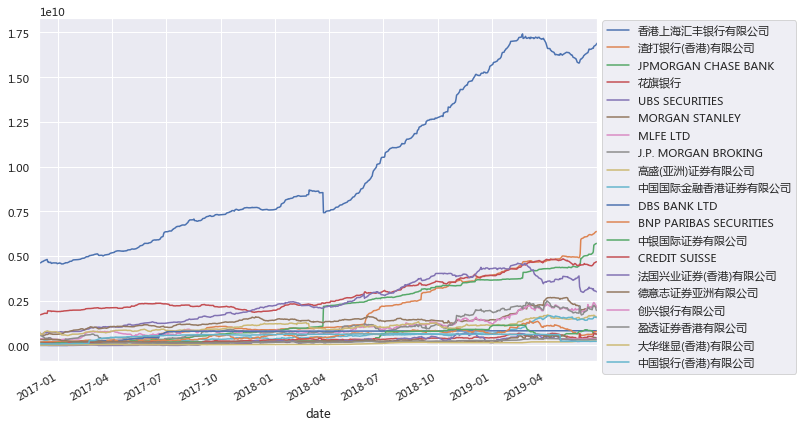

In [233]:
t_share.iloc[:,:20].plot(legend=labels, figsize=(10, 7))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.savefig(r'img\total holding market value.png', bbox_inches ='tight',dpi=100,transparent=True)

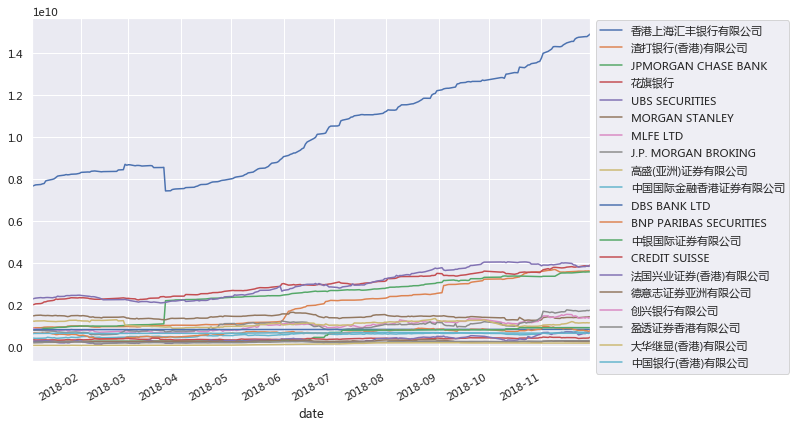

In [232]:
t_share['2018-01-03':'2018-11-30'].iloc[:,:20].plot(legend=labels, figsize=(10,7))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.savefig(r'img\total holding market value - 2018.png', bbox_inches ='tight',dpi=100,transparent=True)

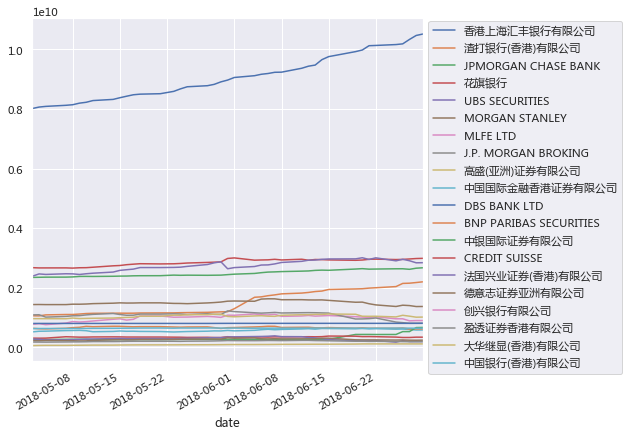

In [231]:
t_share['2018-05':'2018-06'].iloc[:,:20].plot(legend=labels, figsize=(7,7))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.savefig(r'img\total holding market value - 2018-06.png', bbox_inches ='tight',dpi=100,transparent=True)

## 截止目前的持股数据
- 持仓金额
- 各家比重

In [ ]:
def plot_pie(date='2019-06-26', method = 'holdValue', top = 15):
    explode = [0.06]+[0.01]*(top)
    
    snapshot = df_all[df_all['date']==date].groupby('id')[method].sum()
    t = snapshot.sort_values(ascending=False)[:top]
    labels= t.index.to_series().map(mapping).to_list()
    labels.append('other')
    t.loc['other'] = snapshot.sort_values(ascending=False)[top:].sum()
    t.plot(kind='pie', figsize=(8,8), labels = labels,
           shadow=True, startangle=90,
           autopct='%1.1f%%', explode=explode)
    

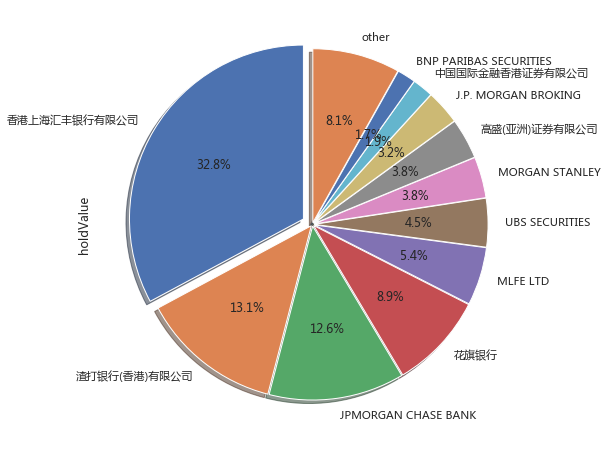

In [236]:
plot_pie(date='2019-06-26',top=11)
plt.savefig(r'img\market share (snapshot)- 2019-06-26.png', bbox_inches ='tight',dpi=100,transparent=True)

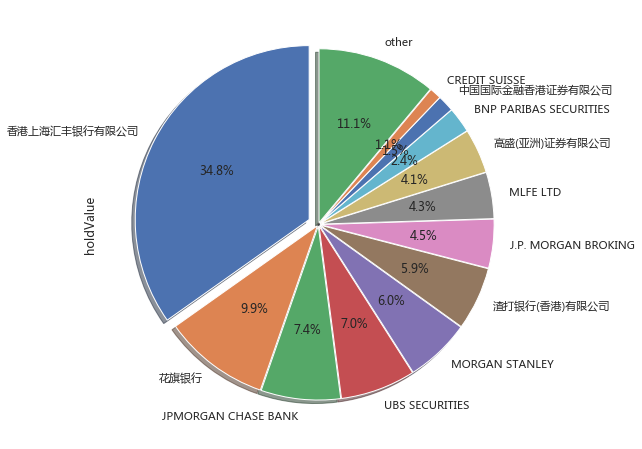

In [229]:
plot_pie(date='2018-06-01',top=12)
plt.savefig(r'img\market share (snapshot)- 2018-06-01.png',bbox_inches ='tight',dpi=100,transparent=True)

# 【4】指数权重调整（微观视角）
- A50指数调整：

- CSI300指数调整

In [6]:
class weight():
    def __init__(self, sheets:dict):
        self.before, self.after = sheets.values()
    def concat(self):
        self.w = pd.concat([self.before.set_index('Ric'), self.after.set_index('Ric')], axis=1, sort=False).fillna(0)
        self.w = self.w.drop(columns=['Bloomberg', 'Basket Quantity', 'Price'])
        self.before, self.after = self.w.iloc[:,0], self.w.iloc[:,1]
w = weight(pd.read_excel(r"Index Weight\A50 Rebal June 2019.xlsx",sheet_name=[0,1]))
w.concat()

In [7]:
(w.after-w.before).sort_values(ascending=False)

300760.SZ    0.003505
601318.SS    0.001293
600036.SS    0.000725
600519.SS    0.000684
601166.SS    0.000447
000651.SZ    0.000401
600887.SS    0.000358
000002.SZ    0.000319
000858.SZ    0.000314
600016.SS    0.000306
600000.SS    0.000296
600030.SS    0.000277
601288.SS    0.000258
600276.SS    0.000233
601398.SS    0.000221
601328.SS    0.000217
600048.SS    0.000206
601668.SS    0.000163
000001.SZ    0.000158
601601.SS    0.000154
601988.SS    0.000140
601169.SS    0.000132
600900.SS    0.000126
002415.SZ    0.000125
600585.SS    0.000119
600104.SS    0.000117
601939.SS    0.000116
601766.SS    0.000106
601818.SS    0.000097
601211.SS    0.000094
600028.SS    0.000094
002304.SZ    0.000089
600050.SS    0.000087
001979.SZ    0.000077
601628.SS    0.000068
601088.SS    0.000067
601186.SS    0.000064
600019.SS    0.000062
601336.SS    0.000059
601857.SS    0.000051
603288.SS    0.000048
002352.SZ    0.000041
600018.SS    0.000034
601998.SS    0.000029
300498.SZ    0.000028
601800.SS 

In [8]:
def to_percent(temp, position):
    return '%.3f'%(100*temp) + '%'

In [9]:
def plot_postion(start, end, top, broker=None):
    t = df_all[df_all['id']==broker].pivot_table(index='date',columns = 'symbol2',values='holdValue')
    t = t.div(t.sum(1),axis=0)
    plt.figure(figsize=(11,5))
    params = {'alpha':0.6, 'kind':'bar','width':0.5}
    t.loc[start].sort_values(ascending=False).iloc[:top].plot(color='r',**params, label='Decrease in Position')
    t.loc[end].sort_values(ascending=False).iloc[:top].plot(color='g',**params, label='Increase in Position')
    plt.xlabel("")
    plt.ylabel("Position (% of total holding values)")
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
    plt.legend(fontsize=13, 
               title=f"From  {start.strftime('%Y-%m-%d')}\nTo      {end.strftime('%Y-%m-%d')}",title_fontsize=15)
    #plt.grid(axis='x')

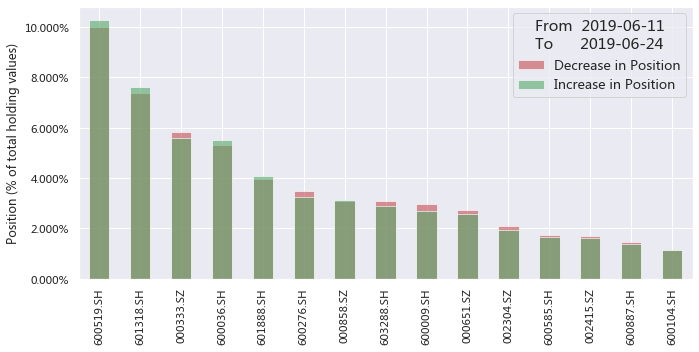

In [10]:
broker = 20
t = df_all[df_all['id']==broker].pivot_table(index='date',columns = 'symbol2',values='holdValue')
plot_postion(broker=broker, start=pd.Timestamp(2019,6,11), end = pd.Timestamp(2019,6,24), top=15)

#plt.savefig('img\\changes in position - June 2019 - %s.png' % mapping[broker], bbox_inches ='tight',dpi=144, transparent=False)

### Story of 温氏股份
14 June 2019 首次纳入指数

In [13]:
symbol = "300498.SZ"; 

In [18]:
# 获取前15大陆股通股东，记作top_brokers
t = df_all[df_all['symbol2']==symbol].pivot_table(index='date',columns='id',values='holdValue')
t = t.div(t.sum(1),axis=0)
top_brokers = t.loc[pd.Timestamp(2019,6,11)].sort_values(ascending=False).iloc[:15].index

In [19]:
# 计算 该股票占该broker的total portfolio比例
t = df_all[df_all['symbol2']==symbol].pivot_table(index='date',columns = 'id',values='holdValue')
total_holding_value = df_all.pivot_table(index='date',columns = 'id',values='holdValue',aggfunc='sum')
t = t/total_holding_value
t = t[top_brokers]

In [36]:
def plot_postion_stock(start, end):
    plt.figure(figsize=(11,5))
    params = {'alpha':0.6, 'kind':'bar','width':0.5}
    t.loc[start].plot(color='r',**params, label='Decrease in Position')
    t.loc[end].plot(color='g',**params, label='Increase in Position')
    plt.xlabel("")
    plt.xticks(ticks=range(0,15), labels=mapping[top_brokers],rotation=57)
    plt.ylabel("Position (% of total holding values)")
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
    plt.legend(fontsize=13, 
               title=f"From  {start.strftime('%Y-%m-%d')}\nTo      {end.strftime('%Y-%m-%d')}",title_fontsize=15)
               

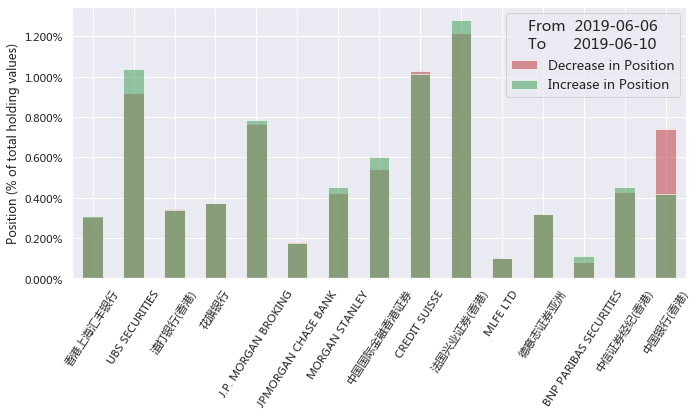

In [39]:
plot_postion_stock(pd.Timestamp(2019,6,6), pd.Timestamp(2019,6,10))
#plt.savefig('img\\changes in position - 温氏股份 - 0606-0613.png', bbox_inches ='tight',dpi=121, transparent=False)

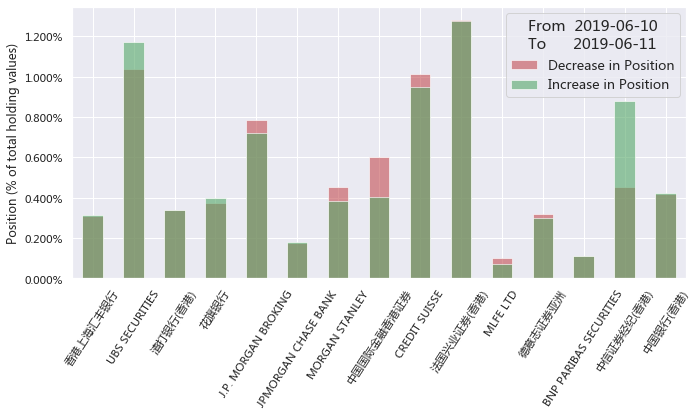

In [45]:
plot_postion_stock(pd.Timestamp(2019,6,10), pd.Timestamp(2019,6,11))
#plt.savefig('img\\changes in position - 温氏股份 - 0606-0613.png', bbox_inches ='tight',dpi=121, transparent=False)

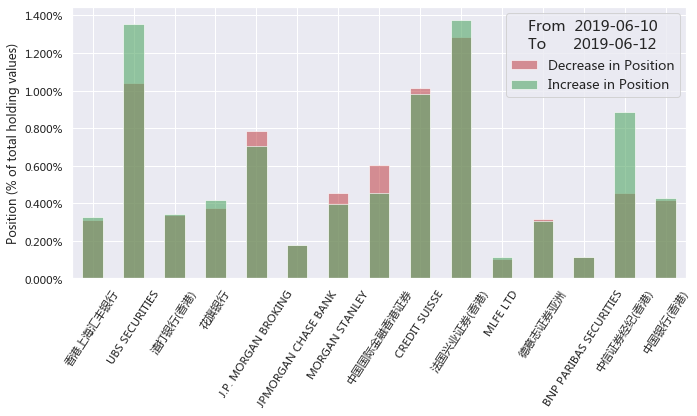

In [49]:
plot_postion_stock(pd.Timestamp(2019,6,10), pd.Timestamp(2019,6,12))

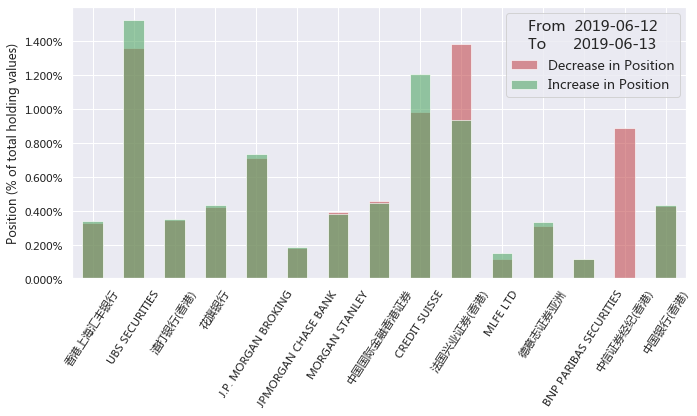

In [46]:
plot_postion_stock(pd.Timestamp(2019,6,12), pd.Timestamp(2019,6,13))

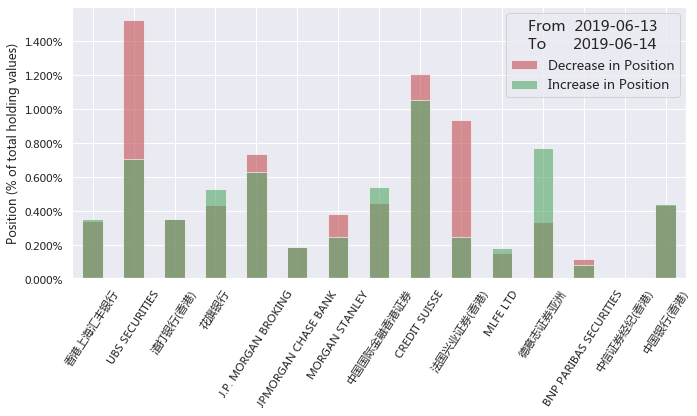

In [47]:
plot_postion_stock(pd.Timestamp(2019,6,13), pd.Timestamp(2019,6,14))

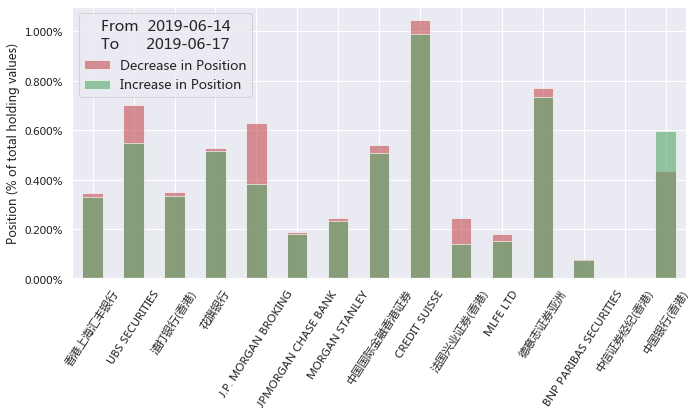

In [48]:
plot_postion_stock(pd.Timestamp(2019,6,14), pd.Timestamp(2019,6,17))

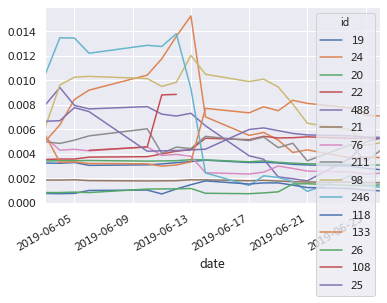

In [29]:
t['2019-06'].plot()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

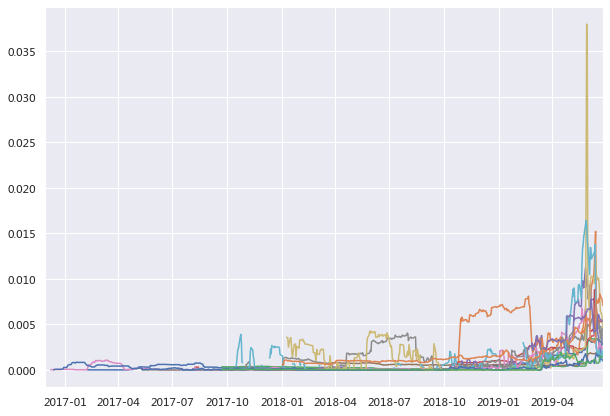

In [32]:
t.plot(legend=mapping[top_brokers], figsize=(10, 7))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
#plt.savefig(r'img\total holding market value.png', bbox_inches ='tight',dpi=100,transparent=True)

In [33]:
mapping[top_brokers]

id
19                   香港上海汇丰银行
24             UBS SECURITIES
20                   渣打银行(香港)
22                       花旗银行
488       J.P. MORGAN BROKING
21        JPMORGAN CHASE BANK
76             MORGAN STANLEY
211                中国国际金融香港证券
98              CREDIT SUISSE
246                法国兴业证券(香港)
118                  MLFE LTD
133                   德意志证券亚洲
26     BNP PARIBAS SECURITIES
108                中信证券经纪(香港)
25                   中国银行(香港)
Name: SHC_NAME, dtype: object

## MSCI Rebalance May 2018


### 先选出MSCI成分股，按照金额加权

In [114]:
msci = pd.read_excel(r"Index Weight\MSCI May 2018.xlsx")
msci['Ticker'] = msci['Ticker'].apply(lambda x: x.replace(' C2','.SZ').replace(' C1','.SH'))

In [115]:
msci['weight'] = msci['Est. Notional to Trade']/msci['Est. Notional to Trade'].sum()

In [117]:
msci.Ticker

0      000001.SZ
1      000002.SZ
2      000027.SZ
3      000039.SZ
4      000050.SZ
5      000060.SZ
6      000063.SZ
7      000069.SZ
8      000157.SZ
9      000166.SZ
10     000333.SZ
11     000338.SZ
12     000402.SZ
13     000413.SZ
14     000423.SZ
15     000425.SZ
16     000538.SZ
17     000559.SZ
18     000568.SZ
19     000581.SZ
20     000625.SZ
21     000627.SZ
22     000630.SZ
23     000651.SZ
24     000656.SZ
25     000709.SZ
26     000725.SZ
27     000728.SZ
28     000768.SZ
29     000776.SZ
         ...    
204    601628.SH
205    601668.SH
206    601669.SH
207    601688.SH
208    601699.SH
209    601718.SH
210    601727.SH
211    601766.SH
212    601788.SH
213    601800.SH
214    601818.SH
215    601857.SH
216    601866.SH
217    601877.SH
218    601888.SH
219    601899.SH
220    601901.SH
221    601919.SH
222    601933.SH
223    601939.SH
224    601958.SH
225    601985.SH
226    601988.SH
227    601992.SH
228    601997.SH
229    601998.SH
230    603288.SH
231    603799.

In [121]:
df_msci = df_all[df_all['symbol2'].isin(msci.Ticker)]

In [123]:
total_holding_value = df_msci.pivot_table(index='date',columns = 'id',values='holdValue',aggfunc='sum')

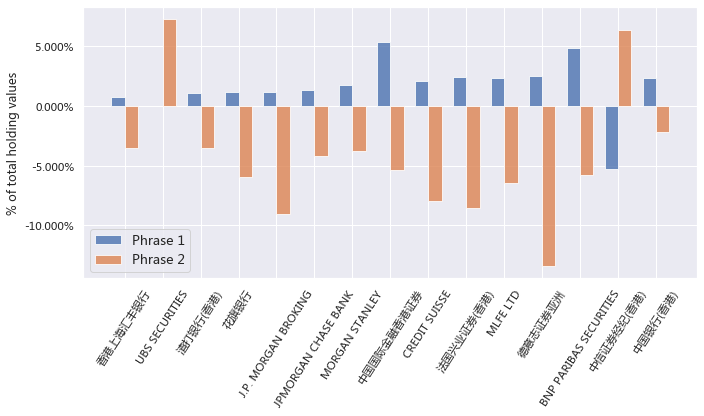

In [126]:
pct_chg = total_holding_value.loc[pd.Timestamp(2018,5,29)]/total_holding_value.loc[pd.Timestamp(2018,5,30)]-1
pct_chg2 = total_holding_value.loc[pd.Timestamp(2018,5,30)]/total_holding_value.loc[pd.Timestamp(2018,5,31)]-1


ind = np.arange(len(top_brokers))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(11,5))
rects1 = ax.bar(ind - width/2, pct_chg[top_brokers], width, alpha=0.8, label='Phrase 1')
rects2 = ax.bar(ind + width/2, pct_chg2[top_brokers], width, alpha=0.8, label='Phrase 2')

#plt.figure(figsize=(11,5))

#pct_chg[top_brokers].plot(**params, label='% Change in Position')
#pct_chg2[top_brokers].plot(**params, label='% Change in Position')
plt.xlabel("")
plt.ylabel("% of total holding values")
plt.xticks(ticks=range(0,15), labels=mapping[top_brokers],rotation=57)
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.legend(fontsize=13)

In [74]:
mapping[top_brokers]

id
19                   香港上海汇丰银行
24             UBS SECURITIES
20                   渣打银行(香港)
22                       花旗银行
488       J.P. MORGAN BROKING
21        JPMORGAN CHASE BANK
76             MORGAN STANLEY
211                中国国际金融香港证券
98              CREDIT SUISSE
246                法国兴业证券(香港)
118                  MLFE LTD
133                   德意志证券亚洲
26     BNP PARIBAS SECURITIES
108                中信证券经纪(香港)
25                   中国银行(香港)
Name: SHC_NAME, dtype: object

In [77]:
total_holding_share = df_all.pivot_table(index='date',columns = 'id',values='holdvol',aggfunc='sum')